# Query Log Analysis

The goal of this notebook is to serve as a way to quickly analyze a query log, based on the following aspects:

- Query-level
- Topic-level
- Session-level
- Term-level
- Entity-level

Our main focus is on understanding how people search, in order to improve entity-oriented search, thus we will tackle these aspects always around the entities.

# Datasets

While we take advantage of the Wikipedia query log for this analysis, we use an intermediate structure, so that you can convert your own query log into our format and analyze it. We begin by applying the analysis to the webis-smc-12 dataset, only then adapting the notebook for the Wikipedia query log.

In [1]:
import math
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
plt.rc("figure", figsize=[15, 3])
matplotlib.style.use('ggplot')
pd.set_option("display.max_rows", 12)

The loader functions will be responsible for loading query log datasets and converting them into a Pandas DataFrame with the following valid columns (only columns with data are required):

- user_id
- query
- timestamp
- click_rank
- click_title
- click_url
- click_timestamp

## webis-smc-12
The Webis Search Mission Corpus 2012 (Webis-SMC-12) contains 8840 entries for 127 users. Each entry includes user ID, query, timestamp, rank and domain URL for clicked results, a mission ID and a comment. Each user is preceded by a line of dashes in the text file.

In [3]:
def load_webis_smc_12(path):
    """Load webis-smc-12.txt file into the notebook query log analysis format."""
   
    def date_parser(date_str):
        if type(date_str) is float and math.isnan(date_str):
            return float("nan")
        else:
            return pd.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            
    def get_sep_row_idx():
        sep_row_idx = []
        
        with open(path, "r") as fp:
            line_number = 0
            for line in fp:
                if line.startswith("---"):
                    sep_row_idx.append(line_number)
                line_number += 1
        
        return sep_row_idx
    
    df = pd.read_csv(
        "data/webis-smc-12.txt",
        sep="\t",
        lineterminator="\n",
        skiprows=get_sep_row_idx(),
        error_bad_lines=False,
        warn_bad_lines=False,
        parse_dates=["TimeStamp"],
        date_parser=date_parser)

    df.drop(columns=["MissionID", "Comment"], inplace=True)
    
    df.rename(
        columns={
            "UserID": "user_id",
            "Query": "query",
            "TimeStamp": "timestamp",
            "ClickRank": "click_rank",
            "ClickDomain": "click_url"
        },
        inplace=True)

    return df

# Dataset loading

Select one of the available dataset loading functions to begin the analysis:

- load_webis_smc_12

In [4]:
qlog = load_webis_smc_12("data/webis-smc-12.txt"); qlog

,user_id,query,timestamp,click_rank,click_url
0,38534,maryland state police,2006-03-01 23:48:15,1.0,http://www.mdsp.org
1,38534,harford county sheriff,2006-03-01 23:55:13,1.0,http://www.harfordsheriff.org
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2.0,http://www.aberdeen-md.org
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1.0,http://www.aberdeen-md.org
4,38534,goody,2006-03-20 16:19:46,NaN,NaN
5,38534,goody,2006-03-20 16:19:47,NaN,NaN
...,...,...,...,...,...
8832,24797984,fw signs from god,2006-05-29 15:42:52,NaN,NaN
8833,24797984,fw signs from god,2006-05-29 15:43:41,NaN,NaN
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN


# Query-level analysis

- Number of queries
- Number of distinct queries
- Distribution of number of queries per user
- Distribution of queries over time
 - Per day
 - For 24h-cycles
 - For weekday-cycles
 - For monthly-cycles

### Total number of queries and distinct queries

In [5]:
qlevel_stats = pd.DataFrame(
    [qlog.shape[0], len(qlog["query"].unique())],
    columns=["value"],
    index=["num_queries", "num_distinct_queries"])
qlevel_stats

,value
num_queries,8838
num_distinct_queries,3736


### Distribution of number of queries per user

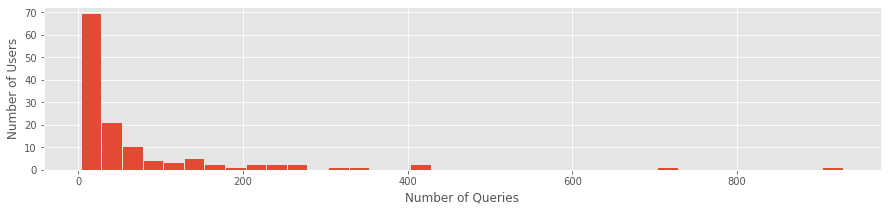

In [6]:
queries_per_user = qlog[["user_id", "query"]] \
    .groupby(["user_id"]) \
    .count()

d_min = queries_per_user["query"].min()
d_max = queries_per_user["query"].max()
bin_width = 25

queries_per_user.plot(kind="hist", bins=range(d_min, d_max+bin_width, bin_width), rwidth=.95, legend=False)
plt.xlabel("Number of Queries")
plt.ylabel("Number of Users")
plt.show()

### Distribution of queries over time

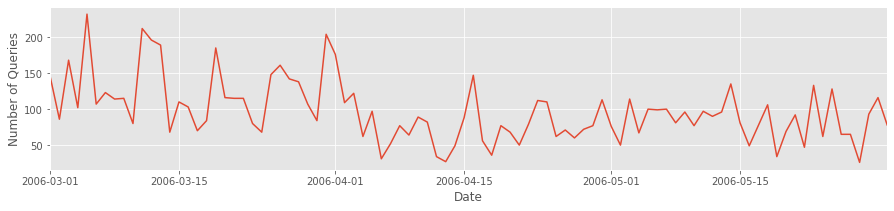

In [7]:
qlog["date"] = qlog["timestamp"].map(lambda t: t.date())

qlog \
    .groupby(["date"]) \
    .size() \
    .plot()
plt.xlabel("Date")
plt.ylabel("Number of Queries")
plt.show()

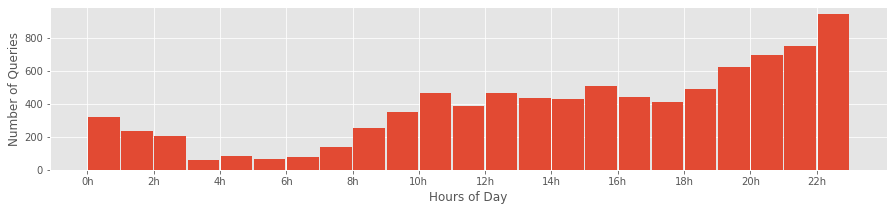

In [8]:
qlog["timestamp"].map(lambda t: t.hour) \
    .plot(kind="hist", bins=23, rwidth=.95)
plt.xticks(range(0, 24, 2), labels=["{0}h".format(h) for h in range(0, 24, 2)])
plt.xlabel("Hours of Day")
plt.ylabel("Number of Queries")
plt.show()

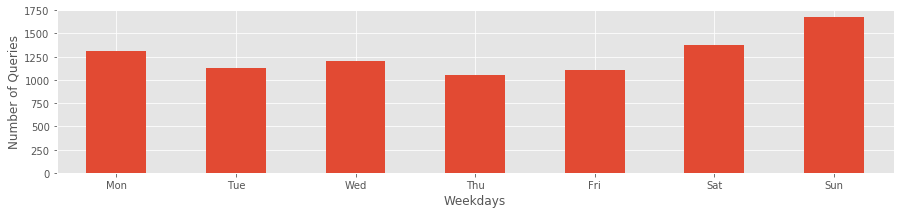

In [9]:
weekdays=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

qlog["weekday"] = qlog["timestamp"].map(lambda t: t.weekday())

qlog \
    .groupby(["weekday"]) \
    .size() \
    .plot(kind="bar")

plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.xlabel("Weekdays")
plt.ylabel("Number of Queries")
plt.show()

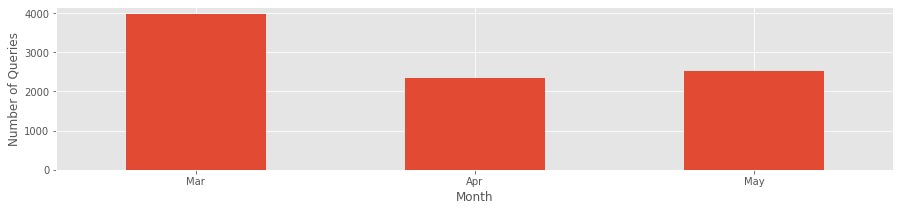

In [10]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
qlog["month"] = qlog["timestamp"].map(lambda t: t.month)

queries_per_month = qlog \
    .groupby(["month"]) \
    .size() \

queries_per_month \
    .plot(kind="bar")

plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.xlabel("Month")
plt.ylabel("Number of Queries")
plt.show()

# Topic-level analysis

In [11]:
#qlog["topic"] = "topics"

# Session-level analysis

In [12]:
#qlog["session_id"] = "sessions" # use, if exists, or compute based on 30 min dead intervals for a user

# Term-level analysis

In [ ]:
#qlog["length"] = "query_chars"
#qlog["num_words"] = "query_words"

# Entity-level analysis

We identified entities taking advantage of the `AhoCorasickEntityExtractor` class available in [Army ANT](https://github.com/feup-infolab/army-ant). We copied [aho_corasick_entity_extractor.py](../../edit/query_log_analysis/aho_corasick_entity_extractor.py) to the notebook workspace and edited it to be usable as a standalone dependency. We then used the English DBpedia names for entities with the class `dbo:Person`, `dbo:Organisation` and `dbp:Place` as the dictionary.

In [66]:
from aho_corasick_entity_extractor import AhoCorasickEntityExtractor
ac = {
    "person": AhoCorasickEntityExtractor(list_path="data/en_dbpedia_person.txt"),
    "organization": AhoCorasickEntityExtractor(list_path="data/en_dbpedia_organization.txt"),
    "place": AhoCorasickEntityExtractor(list_path="data/en_dbpedia_place.txt")
}

In [77]:
from collections import OrderedDict
from functools import reduce

qentities = {k: OrderedDict({}) for k in ac.keys()}

for query in qlog["query"]:
    for d_class in ac.keys():        
        for entity in ac[d_class].extract(query):
            if not entity in qentities[d_class]:
                qentities[d_class][entity] = 1
            else:
                qentities[d_class][entity] += 1

qlog_entities_per_class = {
    k: pd.DataFrame({ "query": list(qentities[k].keys()), "count": list(qentities[k].values()) }) \
        .sort_values(by=["count"], ascending=False)
    for k in ac.keys()
}

#qlog_entities = reduce(lambda left, right: pd.merge(left, right, on=["query", "count"]).set_index(["query", "count"]).sum(axis=1), qlog_entities_per_class.values())
#qlog_entities

ValueError: Cannot merge a Series without a name

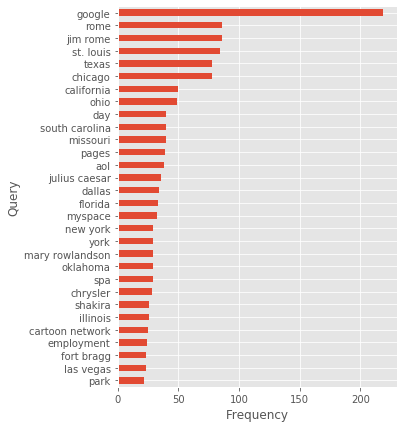

In [62]:
plt.rc("figure", figsize=[5, 7])

ax = qentities.head(30).plot(kind="barh", x="query", y="count", legend=False)
plt.xlabel("Frequency")
plt.ylabel("Query")
plt.gca().invert_yaxis()
plt.show()

plt.rc("figure", figsize=[15, 3])

## Entity-query-level analysis

## Entity-topic-level analysis

## Entity-session-level analysis

## Entity-term-level analysis

## Entity-entity-level analysis